<a href="https://colab.research.google.com/github/alexchen1999/Deep_promoter/blob/master/vae_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn.functional as F

from torch import nn

In [4]:
class VariationalAutoEncoder(nn.Module):
  def __init__(self, input_dim, h_dim=200, z_dim=20):
    super().__init__()

    # Encoder
    self.img_2hid = nn.Linear(input_dim, h_dim)
    self.hid_2mu = nn.Linear(h_dim, z_dim)
    self.hid_2sigma = nn.Linear(h_dim, z_dim)

    # Decoder
    self.z_2hid = nn.Linear(z_dim, h_dim)
    self.hid_2img = nn.Linear(h_dim, input_dim)

    self.relu = nn.ReLU()

  def encode(self, x):
    h = self.relu(self.img_2hid(x))
    mu, sigma = self.hid_2mu(h), self.hid_2sigma(h)
    return mu, sigma

  def decode(self, z):
    h = self.z_2hid(z)
    return torch.sigmoid(self.hid_2img(h)) # Scale from 0 to 1 because MNIST is standardized

  def forward(self, x):
    mu, sigma = self.encode(x)

    # Reparameterization trick
    epsilon = torch.randn_like(sigma) # see https://pytorch.org/docs/stable/generated/torch.randn_like.html: sampling from Gaussian with same tensor shape
    z_reparameterized = mu + sigma * epsilon

    x_reconstructed = self.decode(z_reparameterized)

    return x, mu, sigma

In [5]:
x = torch.randn(4, 28 * 28)
vae = VariationalAutoEncoder(input_dim=784)
x_recon, mu, sigma = vae(x)

print(x_recon.shape)
print(mu.shape)
print(sigma.shape)

torch.Size([4, 784])
torch.Size([4, 20])
torch.Size([4, 20])


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

INPUT_DIM = 784
H_DIM = 300
Z_DIM = 100

NUM_EPOCHS = 10
BATCH_SIZE = 64

LEARNING_RATE = 0.0005

In [19]:
import torchvision.datasets as datasets
from torchvision import transforms

dataset = datasets.MNIST(root="dataset/", train=True, transform=transforms.ToTensor(), download=True)
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: dataset/
    Split: Train
    StandardTransform
Transform: ToTensor()

In [20]:
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm

train_loader = DataLoader(dataset=dataset, batch_size=BATCH_SIZE, shuffle=True)
model = VariationalAutoEncoder(INPUT_DIM, H_DIM, Z_DIM).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

bce_loss = nn.BCELoss(reduction="sum")


for epoch in range(NUM_EPOCHS):
  loop = tqdm(enumerate(train_loader))

  for i, (x, _) in loop:
    x = x.to(device).view(x.shape[0], INPUT_DIM)

    x_recon, mu, sigma = model(x)

    recon_loss = bce_loss(x_recon, x)
    kl_div = -torch.sum(1 + torch.log(sigma.pow(2)) - mu.pow(2) - sigma.pow(2))

    loss = recon_loss + kl_div
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    loop.set_postfix(loss=loss.item())

938it [00:21, 43.52it/s, loss=1.66e+3]
938it [00:21, 44.64it/s, loss=1.53e+3]
938it [00:21, 44.21it/s, loss=1.29e+3]
938it [00:32, 29.02it/s, loss=1.55e+3]
938it [00:21, 44.42it/s, loss=1.27e+3]
938it [00:21, 43.02it/s, loss=1.31e+3]
938it [00:21, 43.24it/s, loss=1.43e+3]
938it [00:21, 43.42it/s, loss=1.55e+3]
938it [00:23, 40.41it/s, loss=1.33e+3]
938it [00:26, 35.36it/s, loss=1.45e+3]


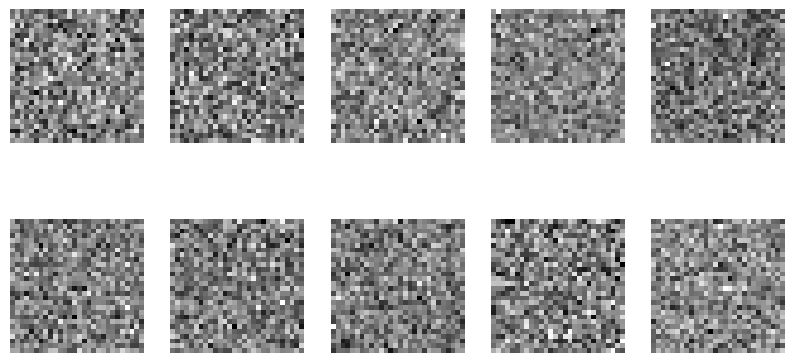

In [21]:
import matplotlib.pyplot as plt
import torchvision.utils as vutils

# Assuming model is already trained

# Number of images to generate
num_samples = 10

# Sample latent vectors from a standard Gaussian distribution
with torch.no_grad():
    z = torch.randn(num_samples, Z_DIM).to(device)

# Pass the latent vectors through the decoder part of the VAE model to generate images
with torch.no_grad():
    generated_images = model.decode(z)

# Reshape generated images to 3D tensor (batch size, channels, height, width) for visualization
generated_images = generated_images.view(-1, 1, 28, 28)

# Convert the PyTorch tensor to a NumPy array
generated_images_numpy = generated_images.cpu().numpy()

# Plot the generated images
plt.figure(figsize=(10, 5))
for i in range(num_samples):
    plt.subplot(2, 5, i + 1)
    plt.imshow(generated_images_numpy[i, 0], cmap='gray')
    plt.axis('off')
plt.show()